Download and unzip dataset

In [ ]:
import requests
from io import BytesIO
from zipfile import ZipFile
dataset = requests.get("https://www.dropbox.com/s/04r31l2whoyljz7/trafficsigns.zip?dl=1")
with ZipFile(BytesIO(dataset.content)) as z:
  z.extractall(".")
classlabels = requests.get("https://www.dropbox.com/s/lte4x88xdk9x4k2/classlabels.txt?dl=1")
with open("classlabels.txt", 'w') as outfile:
  outfile.write(classlabels.content.decode('utf-8'))

Read training set and test set

In [ ]:
from tensorflow.keras.utils import load_img, image_dataset_from_directory
training_set = [(i, l) for i, l in image_dataset_from_directory('trafficsigns/train', image_size = (128, 128), batch_size = None, seed = 123)]
test_set = [(i, l) for i, l in image_dataset_from_directory('trafficsigns/test', image_size = (128, 128), batch_size = None, seed = 123)]

import json
with open("classlabels.txt") as infile:
  labels = dict((int(i), j) for i, j in json.loads(infile.read()).items())
print("The 20 classes are: " + ", ".join(str(l) for l in labels.values()))

Found 1792 files belonging to 20 classes.
Found 1022 files belonging to 20 classes.
The 20 classes are: limit30, limit50, limit60, limit80, noleft, noright, nouturn, gostraight, goleft, goright, keepright, roundabout, danger, pedestrcross, bikecross, childcross, traincross, construction, nostopping, noentry


Keep only specific class labels

In [ ]:
from ctypes import sizeof
labels_to_keep = list(range(20)) # Change this to determine which labels to keep (or change to list(range(20)) to keep all labels)
num_classes = len(labels_to_keep)

import numpy as np
x_train = np.array([image for image, label in training_set if label in labels_to_keep])
y_train = np.array([labels_to_keep.index(label) for image, label in training_set if label in labels_to_keep])
x_test = np.array([image for image, label in test_set if label in labels_to_keep])
y_test = np.array([labels_to_keep.index(label) for image, label in test_set if label in labels_to_keep])


finallabels = dict([(i, labels[l]) for i, l in enumerate(labels_to_keep)])
print("The " + str(num_classes) + " classes are: " + ", ".join(str(l) for l in finallabels.values()))

The 20 classes are: limit30, limit50, limit60, limit80, noleft, noright, nouturn, gostraight, goleft, goright, keepright, roundabout, danger, pedestrcross, bikecross, childcross, traincross, construction, nostopping, noentry


Plot example data

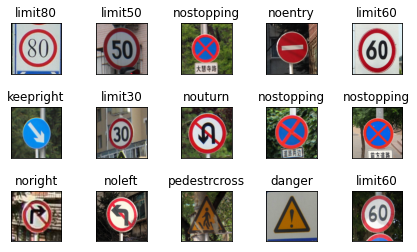

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import array_to_img
fig = plt.figure()
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.tight_layout()
  img = array_to_img(x_train[i])
  plt.imshow(img)
  plt.title(finallabels[y_train[i]])
  plt.xticks([])
  plt.yticks([])

Set model parameters and use the image data format of Tensorflow

In [ ]:
img_width, img_height = 128, 128
input_shape = (img_width, img_height, 3)

In [ ]:
import keras
num_classes = 20
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)
print(type(y_train))

<class 'numpy.ndarray'>


Create a neural network with 4 convolutional layers and 2 dense layers

In [ ]:
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from keras.models import Sequential

model = Sequential()
model.add(Convolution2D(32, (5, 5), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32, (5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32, (5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, (5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.35))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='sigmoid'))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 batch_normalization (BatchN  (None, 124, 124, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 32)        25632     
                                                                 
 batch_normalization_1 (Batc  (None, 58, 58, 32)       128       
 hNormalization)                                                 
                                                        

Perform augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1. / 255, shear_range=0.2, zoom_range=0.2,brightness_range=[0.4,0.9], validation_split=0.3)
test_datagen=ImageDataGenerator(rescale=1. / 255, shear_range=0.2, zoom_range=0.2,brightness_range=[0.4,0.9])

Train the model

In [ ]:
history=model.fit(datagen.flow(x_train,y_train,batch_size=16,seed=0,subset='training'),steps_per_epoch=len(x_train)*0.3// 16,epochs=50,verbose=1,validation_data=datagen.flow(x_train,y_train,batch_size=16,seed=0,subset='validation') ,shuffle=True)

Epoch 1/50
33/33 [==============================] - 37s 1s/step - loss: 3.0460 - accuracy: 0.3314 - val_loss: 2.9217 - val_accuracy: 0.1620
Epoch 2/50
33/33 [==============================] - 35s 1s/step - loss: 1.5945 - accuracy: 0.5720 - val_loss: 2.9190 - val_accuracy: 0.1192
Epoch 3/50
33/33 [==============================] - 36s 1s/step - loss: 1.3402 - accuracy: 0.6146 - val_loss: 3.0415 - val_accuracy: 0.0745
Epoch 4/50
33/33 [==============================] - 35s 1s/step - loss: 1.0570 - accuracy: 0.6840 - val_loss: 2.5191 - val_accuracy: 0.1899
Epoch 5/50
33/33 [==============================] - 35s 1s/step - loss: 0.8498 - accuracy: 0.7254 - val_loss: 2.6560 - val_accuracy: 0.1266
Epoch 6/50
33/33 [==============================] - 37s 1s/step - loss: 0.6973 - accuracy: 0.7689 - val_loss: 2.1320 - val_accuracy: 0.2719
Epoch 7/50
33/33 [==============================] - 35s 1s/step - loss: 0.6050 - accuracy: 0.8125 - val_loss: 1.6346 - val_accuracy: 0.4953
Epoch 8/50
33/33 [==

Training and validation visualization

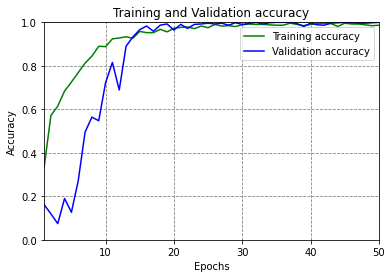

In [ ]:
import matplotlib.pyplot as plt
train_acc=history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1,51)
plt.plot(epochs, train_acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.xlim(1,50)
plt.ylim(0,1)
plt.grid(ls='dashed',c='grey')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

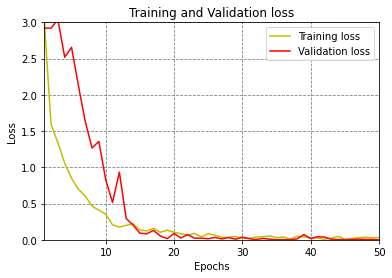

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,51)
plt.plot(epochs, train_loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlim(1,50)
plt.ylim(0,3)
plt.grid(ls='dashed',c='grey')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Get loss and accuracy on test set

In [ ]:
score = model.evaluate(test_datagen.flow(x_test, y_test,batch_size=16,seed=0), verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

64/64 [==============================] - 16s 247ms/step - loss: 0.6226 - accuracy: 0.8933
Test loss: 0.6226303577423096
Test accuracy: 0.89334636926651


Get Classification Report

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

def cat_to_num(c):
  for i in range(len(c)+1):
    if c[i]==1:
      return i
test=test_datagen.flow(x_test, y_test,batch_size=16,seed=0)
y_true=[]
for i in range (64):
  b=test[i]
  b=b[1]
  for j in range(len(b)):
    y_true.append(cat_to_num(b[j]))
pred = model.predict(test).argmax(axis=-1)
print(y_true)
print(pred)
print(classification_report(y_true, pred,target_names=finallabels.values()))

64/64 [==============================] - 18s 278ms/step
[16, 10, 18, 18, 11, 18, 2, 13, 18, 3, 2, 8, 4, 19, 0, 1, 5, 5, 10, 10, 19, 0, 18, 11, 18, 3, 19, 7, 10, 10, 14, 13, 6, 15, 2, 18, 14, 19, 0, 18, 0, 19, 18, 19, 10, 4, 2, 2, 18, 18, 18, 15, 6, 18, 19, 4, 11, 1, 8, 10, 4, 5, 5, 18, 4, 1, 4, 10, 16, 4, 4, 10, 19, 3, 5, 4, 3, 0, 4, 16, 6, 18, 1, 4, 4, 10, 4, 4, 4, 11, 18, 2, 9, 4, 18, 18, 6, 18, 1, 5, 1, 4, 5, 10, 10, 4, 3, 2, 11, 18, 18, 10, 18, 4, 10, 5, 18, 9, 4, 5, 18, 2, 18, 5, 19, 10, 5, 4, 13, 4, 18, 10, 3, 10, 5, 13, 2, 15, 1, 19, 10, 15, 2, 13, 4, 6, 15, 13, 4, 13, 0, 13, 6, 10, 19, 3, 4, 18, 1, 9, 17, 4, 2, 18, 5, 10, 0, 10, 4, 18, 9, 4, 1, 5, 18, 18, 18, 5, 5, 3, 18, 10, 4, 18, 3, 10, 5, 1, 10, 5, 19, 0, 19, 18, 19, 4, 19, 10, 18, 5, 9, 5, 7, 10, 5, 6, 18, 18, 4, 10, 10, 10, 19, 18, 4, 13, 10, 18, 18, 18, 5, 3, 13, 3, 5, 4, 0, 18, 9, 10, 18, 4, 1, 2, 6, 18, 6, 3, 4, 13, 18, 4, 13, 9, 9, 5, 5, 0, 5, 9, 18, 4, 18, 3, 5, 6, 19, 13, 2, 10, 5, 15, 16, 11, 0, 4, 4, 3, 19, 1, 6, 

Save model

In [ ]:
model.save('model_1c.h5')